# Evaluate the capability of emotion embedding module

##### HOW?

Extract from the module only the emotion embedder, compute the embeddings of sample batch from each class (in this case the 4 emotions) and plot the representation in a *low dimensionality space* with a dimensionality reduction procedure.


### Load Libraries

In [27]:
# load packages
import yaml
from munch import Munch
import torch
import torchaudio
import librosa
import pandas as pd
from models import StyleEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Dict, List

to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300)
mean, std = -4, 4

### Define notebook variable

| Variable Name | Meaning |
|:---:|:---:|
| DEVICE | Device on which computations are executed |
| DATA_PATH | Relative path of the file that contains the **sample set** |
| DATA_HEADER | Header definition of the DATA_PATH file |
| DATA_SEPARETOR | Separetor of the DATA_PATH file |
| MODEL_CODE | The Model Code |
| CHECKPOINT_NAME | The name of the checkpoint |
| EMOTION_EMBEDDER_CODE* | The name of the module that provide the emotion embedding |


\* **ATTENTION** the name is "model dependent" in the sense that it can be both style_encoder or emotion_encoder, it depends on:
- The experiment
- The developer :*)

In [6]:
DEVICE = "cpu"
DATA_PATH = "Data/emotion_embedding_test_file.txt"
DATA_HEADER = ["file_path","emotion_id"]
DATA_SEPARETOR = "|"
MODEL_CODE = "Experiment-2"
CHECKPOINT_NAME = "epoch.pth"
EMOTION_EMBEDDER_CODE = "style_encoder"

%matplotlib inline

### Function definition

In [22]:
def preprocess(wave: torch.Tensor) -> torch.Tensor:
    """ From a wave tensor produce a spectrogram representation

    Args:
        wave (Sample,1): The waveform of the source audio, it depends from audio length and sampling rate.

    Returns:
       (AudioChannel, MelBandChannel, TemporalFrame): The spectrogram of the relative waveform.
    """  
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor) # Out: (AudioChannel, MelBandChannel, TemporalFrame)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def build_model(model_params: Dict[str, int]) -> Munch:
    """Create the emotion embedder

    Args:
        model_params (Dict[str, int]): key: model parameter, value: value of the parameter

    Returns:
        Munch: The emotion embedder
    """    
    args = Munch(model_params)
    style_encoder = StyleEncoder(args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim)
    model = Munch(style_encoder=style_encoder)
    params = torch.load(f"./Models/{MODEL_CODE}/{CHECKPOINT_NAME}", map_location=DEVICE)
    params = params['model_ema']
    _ = [model[key].load_state_dict(params[key]) for key in model if key == EMOTION_EMBEDDER_CODE]
    _ = [model[key].eval() for key in model if key == EMOTION_EMBEDDER_CODE]
    model.style_encoder = model.style_encoder.to(DEVICE)
    return model

def compute_style(model: Munch, sample_dicts: Dict[int, tuple]) -> List[torch.Tensor]:
    """Compute style for a batch of sample

    Args:
        model (Munch): The model.
        sample_dicts (Dict[int, tuple]): key: sample_id, value: (tuple) -> (relative audio path, emotion id) 

    Returns:
        List[(1, embedding_dim)]: The list of embeddings obtained from the source samples
    """    
    reference_embeddings = []
    for key, (path, emotion_id) in sample_dicts.items():
        wave, sr = librosa.load(path, sr=24000)
        audio, index = librosa.effects.trim(wave, top_db=30)
        if sr != 24000:
            wave = librosa.resample(wave, sr, 24000)
        mel_tensor = preprocess(wave).to(DEVICE)
        with torch.no_grad():
            label = torch.LongTensor([emotion_id])
            ref = model.style_encoder(mel_tensor.unsqueeze(1), label) # Out (1, embedding_dim)
        reference_embeddings.append(ref)
    return reference_embeddings

### Load model

**ATTENTION** the key used on the list generator is "model dependent" in the sense that it can be both style_encoder or emotion_encoder, it depends on:
- The experiment
- The developer :*)

In [23]:
with open(f'./Models/{MODEL_CODE}/config.yml') as f:
    starganv2_config = yaml.safe_load(f)
starganv2 = build_model(model_params=starganv2_config["model_params"])

asfsfsdfd


### Retrieve embeddings

In [25]:
# with reference, using style encoder
dataframe = pd.read_csv(DATA_PATH, sep=DATA_SEPARETOR, names=DATA_HEADER)
emotion_dict ={}
speaker_dicts = {}
for index,speaker_emotion in dataframe.groupby("emotion_id"):
    speaker_dicts={}
    for index, row in speaker_emotion.iterrows():
        speaker_dicts[index] = (row["file_path"], row["emotion_id"])
    emotion_dict[speaker_emotion.iloc[0].emotion_id] = speaker_dicts

emotion_embeddings = {}
embeddings = []
for emotion_idx, data in emotion_dict.items():
    _temp_result=compute_style(starganv2, data)
    emotion_embeddings[emotion_idx]=_temp_result
    embeddings += _temp_result

embeddings = [embedding.to("cpu").squeeze(0).tolist() for embedding in embeddings]



KeyboardInterrupt: 

### Lower dimensionality representation

1) PCA
2) Manyfold MDS

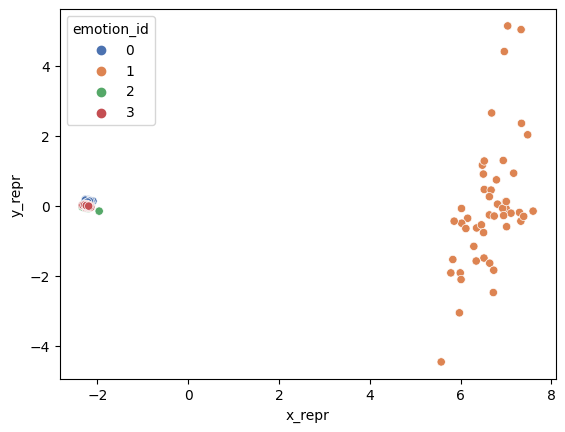

In [34]:
dataframe = pd.read_csv(DATA_PATH, sep=DATA_SEPARETOR, names=DATA_HEADER)
pca = PCA(2)
df = pca.fit_transform(embeddings)
df = pd.DataFrame(df, columns=["x_repr","y_repr"])
dataframe_with_embedding = pd.concat([dataframe,df], axis=1)
sns.scatterplot(data=dataframe_with_embedding, x="x_repr", y="y_repr", hue="emotion_id", palette="deep")
plt.show()

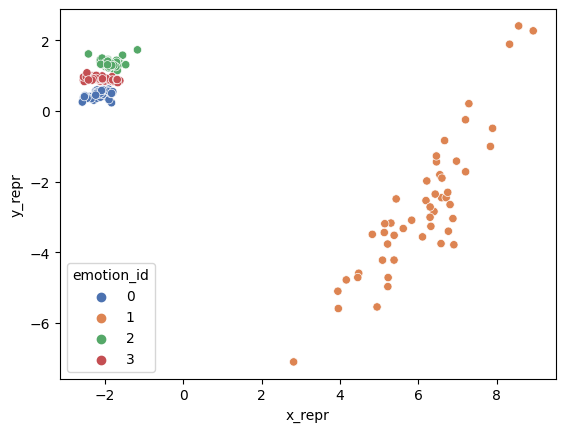

In [51]:
mds = MDS(n_components=2, random_state=4)
df = mds.fit_transform(embeddings)
df = pd.DataFrame(df, columns=["x_repr","y_repr"])
dataframe_with_embedding = pd.concat([dataframe,df], axis=1)
sns.scatterplot(data=dataframe_with_embedding, x="x_repr", y="y_repr", hue="emotion_id", palette="deep")
plt.show()